In [ ]:
import pandas as pd
import numpy as np
from mp_api.client import MPRester

# Replace with your API key
# Get from https://materialsproject.org/open
API_KEY = ""

All libraries imported successfully.


### Data Collection

In [ ]:
def get_electrolyte_data():
    with MPRester(API_KEY) as mpr:
        # Filters for nitride-based electrolytes
        elements = ["N"] # Must include nitrogen 
        exlude_elements = ["S", "O"] # Filter out oxynitrides and thionitrides
        num_elements = (2, 6) # 2–6 elements for simple and complex nitrides

        # Required features
        fields = [
            "material_id",
            "formula_pretty",
            "band_gap",
            "volume",
            "cbm", # Conduction band minimum
            "density",
            "density_atomic",
            "efermi",
            "energy_above_hull",
            "num_magnetic_sites",
            "num_unique_magnetic_sites"
        ]

        # Query for nitride materials
        try:
            print("Querying Materials Project with filters:")
            docs = mpr.materials.summary.search(
                elements=elements,
                exclude_elements=exlude_elements,
                num_elements=num_elements,
                # filter for practical electrolytes
                energy_above_hull=(None, 0.15), # Stable or near-stable
                fields=fields,
                chunk_size=500
            )
            print(f"Retrieved {len(docs)} materials")
            return docs
        except Exception as e:
            print(f"Error: {e}")
            return []

docs = get_electrolyte_data()

df = pd.DataFrame([doc.dict() for doc in docs])

print(f"Collected {len(df)} materials")
print(f"Features: {list(df.columns)}")

#First few rows of the DataFrame:
print(df.head())
# Save raw data
df.to_csv("nitride_electrolyte_data.csv", index=False)

Querying Materials Project with filters:


Retrieving SummaryDoc documents: 100%|██████████| 3055/3055 [00:03<00:00, 972.26it/s] 


Retrieved 3055 materials
Collected 3055 materials
Features: ['builder_meta', 'nsites', 'elements', 'nelements', 'composition', 'composition_reduced', 'formula_pretty', 'formula_anonymous', 'chemsys', 'volume', 'density', 'density_atomic', 'symmetry', 'property_name', 'material_id', 'deprecated', 'deprecation_reasons', 'last_updated', 'origins', 'warnings', 'structure', 'task_ids', 'uncorrected_energy_per_atom', 'energy_per_atom', 'formation_energy_per_atom', 'energy_above_hull', 'is_stable', 'equilibrium_reaction_energy_per_atom', 'decomposes_to', 'xas', 'grain_boundaries', 'band_gap', 'cbm', 'vbm', 'efermi', 'is_gap_direct', 'is_metal', 'es_source_calc_id', 'bandstructure', 'dos', 'dos_energy_up', 'dos_energy_down', 'is_magnetic', 'ordering', 'total_magnetization', 'total_magnetization_normalized_vol', 'total_magnetization_normalized_formula_units', 'num_magnetic_sites', 'num_unique_magnetic_sites', 'types_of_magnetic_species', 'bulk_modulus', 'shear_modulus', 'universal_anisotropy', 

### Data Cleaning & Preprocessing
- Handle missing values (especially for cbm which is critical for band gap prediction & band gap itself)
- Remove outliers using IQR method for key numerical features
- Check data quality and consistency

In [ ]:
# Check initial data 
print(f"Dataset shape: {df.shape}")
print(f"Missing values per column:")
print(df.isnull().sum())

# Remove records with missing cbm values 
initial_count = len(df)
df_clean = df.dropna(subset=['cbm']).copy()
print(f"Removed {initial_count - len(df_clean)} records with missing cbm values")

# Remove records with missing band gap which is our target variable
df_clean = df_clean.dropna(subset=['band_gap']).copy()
print(f"Dataset shape after removing missing values: {df_clean.shape}")

# Round numerical features to reasonable precision
df_clean['band_gap'] = df_clean['band_gap'].round(3)
df_clean['volume'] = df_clean['volume'].round(2)
df_clean['cbm'] = df_clean['cbm'].round(3)
df_clean['density'] = df_clean['density'].round(3)
df_clean['density_atomic'] = df_clean['density_atomic'].round(4)
df_clean['efermi'] = df_clean['efermi'].round(3)

# Simple outlier removal using IQR method for all numerical features
numerical_cols = ['band_gap', 'volume', 'cbm', 'density', 'density_atomic', 'efermi', 'energy_above_hull']
outlier_count = 0

for col in numerical_cols:
    if col in df_clean.columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        before_count = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        removed = before_count - len(df_clean)
        outlier_count += removed

        if removed > 0:
            print(f"Removed {removed} outliers from {col}")

print(f"\nTotal outliers removed: {outlier_count}")
print(f"Final clean dataset shape: {df_clean.shape}")
print(f"Data retention rate: {len(df_clean)/initial_count:.1%}")

# Save cleaned data
df_clean.to_csv("nitride_electrolyte_clean.csv", index=False)
print("Saved cleaned dataset to nitride_electrolyte_clean.csv")


=== Initial Data Quality Check ===
Dataset shape: (3055, 70)
Missing values per column:
builder_meta            3055
nsites                  3055
elements                3055
nelements               3055
composition             3055
                        ... 
possible_species        3055
has_props               3055
theoretical             3055
database_Ids            3055
fields_not_requested       0
Length: 70, dtype: int64

Removed 1099 records with missing cbm values
Dataset shape after removing missing critical values: (1956, 70)
Removed 14 outliers from band_gap
Removed 96 outliers from volume
Removed 96 outliers from cbm
Removed 41 outliers from density
Removed 37 outliers from density_atomic
Removed 1 outliers from efermi

Total outliers removed: 285
Final clean dataset shape: (1671, 70)
Data retention rate: 54.7%
Saved cleaned dataset to nitride_electrolyte_clean.csv


### Feature Engineering

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Select the 9 features (8 input + 1 output) as per requirements
selected_features = [
    'volume',
    'cbm',
    'density',
    'density_atomic',
    'efermi',
    'energy_above_hull',
    'num_magnetic_sites',
    'num_unique_magnetic_sites',
    'band_gap' # Target  
]

df_features = df_clean[selected_features].copy()

print(f"Selected {len(selected_features)} features")
print(f"Dataset shape: {df_features.shape}")

# Input features for normalization w/o target
input_features = ['volume', 'cbm', 'density', 'density_atomic', 'efermi', 'energy_above_hull', 'num_magnetic_sites', 'num_unique_magnetic_sites']

print(f"\nBefore normalization - Feature ranges:")
for feature in input_features:
    min_val = df_features[feature].min()
    max_val = df_features[feature].max()
    print(f"{feature}: [{min_val:.3f}, {max_val:.3f}] (range: {max_val-min_val:.3f})")

print(f"band_gap range:[{df_features['band_gap'].min():.3f}, {df_features['band_gap'].max():.3f}] eV")

# Perform Min-Max normalization to input features only
scaler = MinMaxScaler()
df_features[input_features] = scaler.fit_transform(df_features[input_features])

print(f"\nAfter normalization:")
for feature in input_features:
    min_val = df_features[feature].min()
    max_val = df_features[feature].max()
    print(f"{feature}: [{min_val:.3f}, {max_val:.3f}]")

# Save feature-engineered dataset and scaler for later use
df_features.to_csv("nitride_electrolyte_features.csv", index=False)

print(df_features.head())


Selected 9 features
Dataset shape: (1671, 9)

Before normalization - Feature ranges:
volume: [16.500, 1930.150] (range: 1913.650)
cbm: [-0.861, 8.597] (range: 9.458)
density: [0.630, 8.656] (range: 8.026)
density_atomic: [6.711, 29.277] (range: 22.566)
efermi: [-4.295, 8.430] (range: 12.725)
energy_above_hull: [0.000, 0.149] (range: 0.149)
num_magnetic_sites: [0.000, 48.000] (range: 48.000)
num_unique_magnetic_sites: [0.000, 18.000] (range: 18.000)
Target variable range: band_gap [0.000, 7.104] eV

After normalization - Input features scaled to [0,1]:
volume: [0.000, 1.000]
cbm: [0.000, 1.000]
density: [0.000, 1.000]
density_atomic: [0.000, 1.000]
efermi: [0.000, 1.000]
energy_above_hull: [0.000, 1.000]
num_magnetic_sites: [0.000, 1.000]
num_unique_magnetic_sites: [0.000, 1.000]
Target variable (unchanged): band_gap [0.000, 7.104] eV
Saved feature-engineered dataset to nitride_electrolyte_features.csv

First 5 rows of processed dataset:
     volume       cbm   density  density_atomic  

### Exploratory Data Analysis 

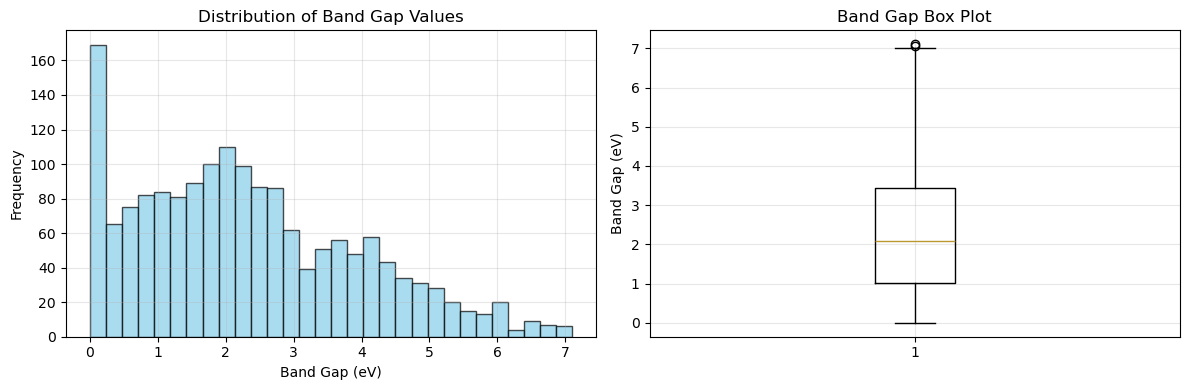

Band Gap Statistics:
Mean: 2.311 eV
Std: 1.625 eV
Range: 0.000 - 7.104 eV

Correlations with Band Gap (sorted by absolute value):
efermi                   : -0.604
density                  : -0.577
density_atomic           : -0.358
num_magnetic_sites       : -0.228
num_unique_magnetic_sites: -0.209
volume                   :  0.094
cbm                      : -0.082
energy_above_hull        :  0.007


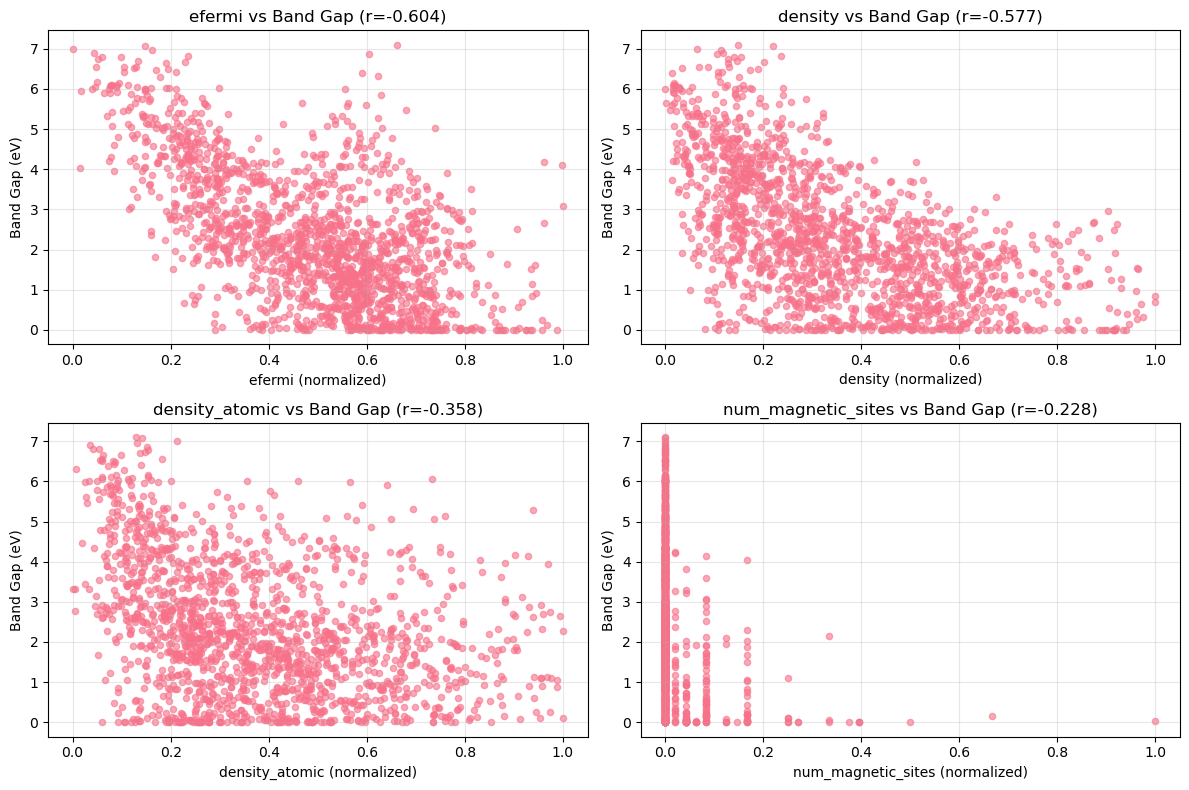

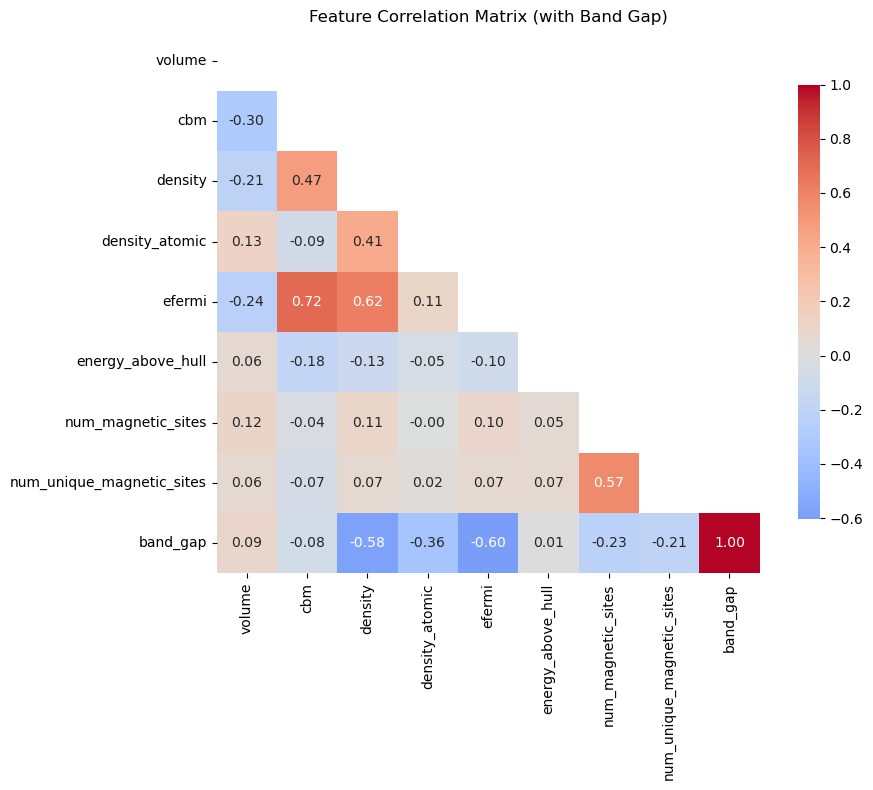

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('default')
sns.set_palette("husl")

# Target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Band gap histogram
axes[0].hist(df_features['band_gap'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_xlabel('Band Gap (eV)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Band Gap Values')
axes[0].grid(True, alpha=0.3)

# Band gap box plot
axes[1].boxplot(df_features['band_gap'])
axes[1].set_ylabel('Band Gap (eV)')
axes[1].set_title('Band Gap Box Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Band Gap Statistics:")
print(f"Mean: {df_features['band_gap'].mean():.3f} eV")
print(f"Std: {df_features['band_gap'].std():.3f} eV")
print(f"Range: {df_features['band_gap'].min():.3f} - {df_features['band_gap'].max():.3f} eV")

# Correlation analysis with target
correlations = df_features[input_features].corrwith(df_features['band_gap']).sort_values(key=abs, ascending=False)
print(f"\nCorrelations with Band Gap (sorted by absolute value):")
for feature, corr in correlations.items():
    print(f"{feature:25}: {corr:6.3f}")

# Key feature relationships
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

# Most correlated features vs band gap
top_features = correlations.head(4).index

for i, feature in enumerate(top_features):
    axes[i].scatter(df_features[feature], df_features['band_gap'], alpha=0.6, s=20)
    axes[i].set_xlabel(f'{feature} (normalized)')
    axes[i].set_ylabel('Band Gap (eV)')
    axes[i].set_title(f'{feature} vs Band Gap (r={correlations[feature]:.3f})')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature correlation matrix including band_gap
plt.figure(figsize=(10, 8))

# Include all features including band_gap for full correlation matrix
all_features = input_features + ['band_gap']
corr_matrix = df_features[all_features].corr()

# Create mask for upper triangle (excluding the band_gap row)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
mask[-1, :] = False  # Show the bottom row (band_gap correlations)

sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix (with Band Gap)')
plt.tight_layout()
plt.show()



### Train-Test Split

Feature matrix shape: (1671, 8)
Target vector shape: (1671,)

Train-Test Split Results:
Training set: 1336 samples (80.0%)
Testing set: 335 samples (20.0%)

Target Variable Distribution Comparison:
Training set - Mean: 2.300 eV, Std: 1.605 eV
Testing set  - Mean: 2.356 eV, Std: 1.703 eV


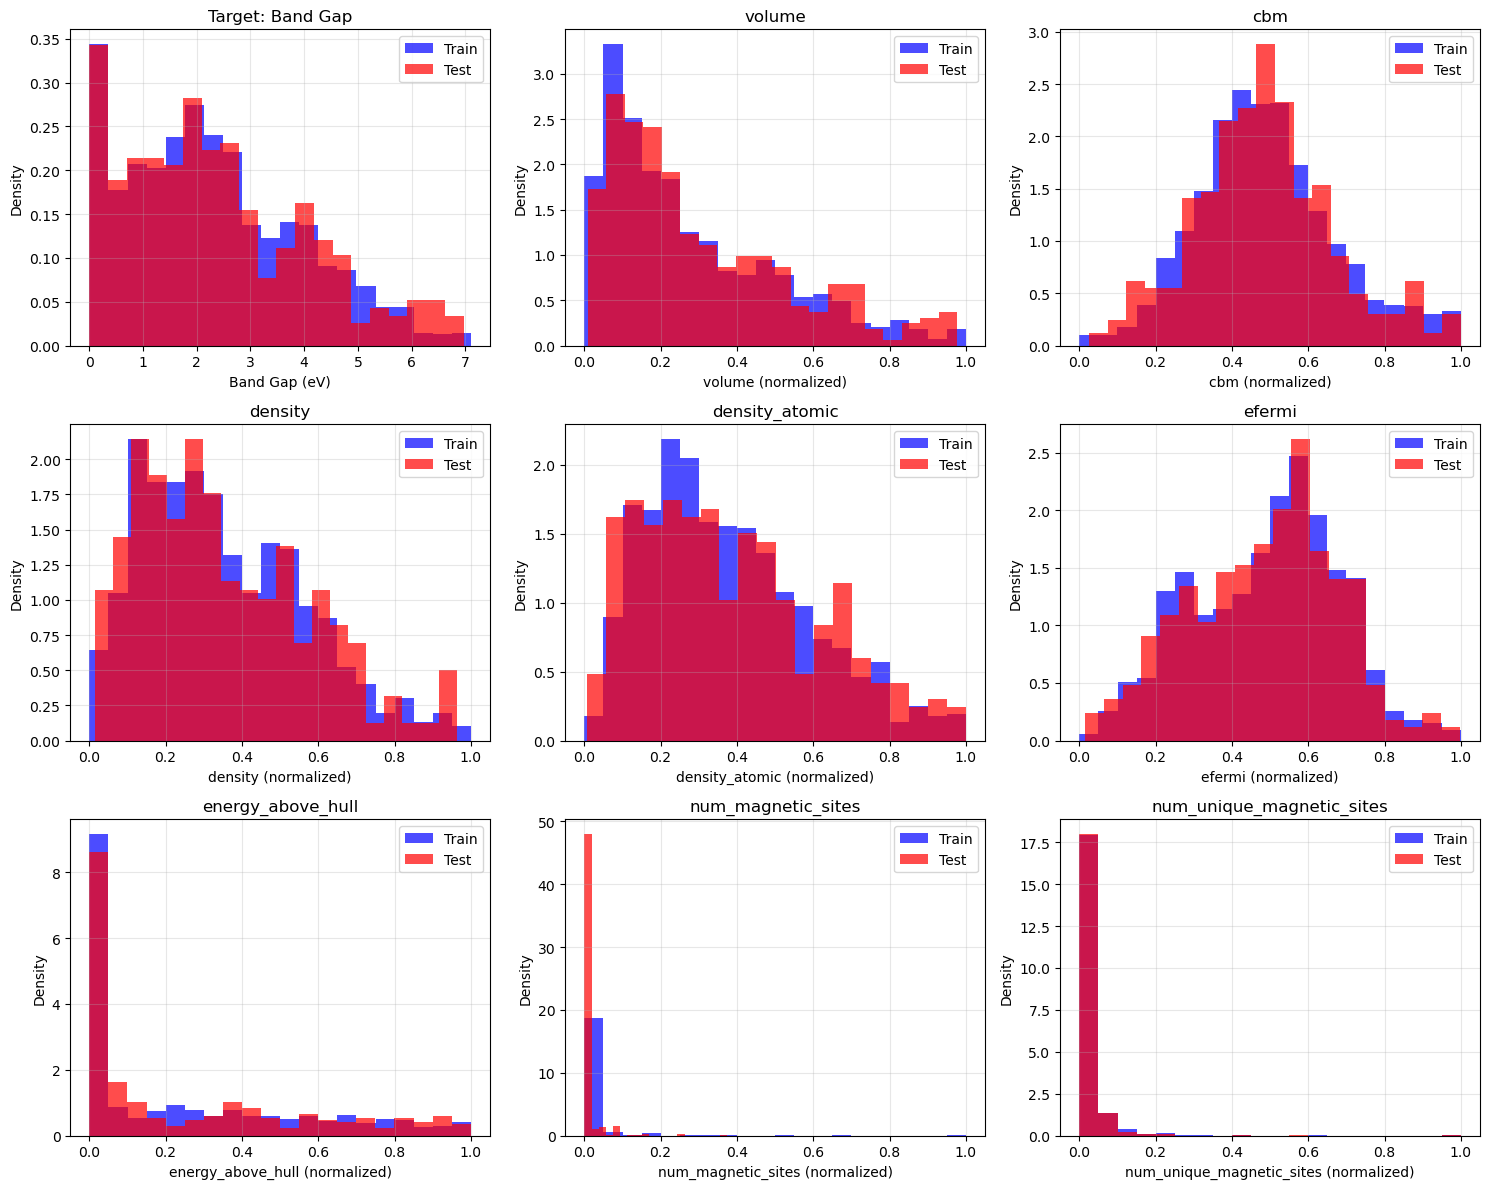

In [ ]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Separate features and target
X = df_features[input_features].copy()
y = df_features['band_gap'].copy()

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data 80:20 for training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=123,  
)

# Verify similar distributions in train and test sets
print(f"\nTarget Variable Distribution Comparison:")
print(f"Training set - Mean: {y_train.mean():.3f} eV, Std: {y_train.std():.3f} eV")
print(f"Testing set  - Mean: {y_test.mean():.3f} eV, Std: {y_test.std():.3f} eV")

# Visualize all feature distributions
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

# Target variable first
axes[0].hist(y_train, bins=20, alpha=0.7, label='Train', color='blue', density=True)
axes[0].hist(y_test, bins=20, alpha=0.7, label='Test', color='red', density=True)
axes[0].set_xlabel('Band Gap (eV)')
axes[0].set_ylabel('Density')
axes[0].set_title('Target: Band Gap')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# All input features
for i, feature in enumerate(input_features):
    axes[i+1].hist(X_train[feature], bins=20, alpha=0.7, label='Train', color='blue', density=True)
    axes[i+1].hist(X_test[feature], bins=20, alpha=0.7, label='Test', color='red', density=True)
    axes[i+1].set_xlabel(f'{feature} (normalized)')
    axes[i+1].set_ylabel('Density')
    axes[i+1].set_title(f'{feature}')
    axes[i+1].legend()
    axes[i+1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### XGBoost Band Gap Prediction Model

This section implements the core machine learning pipeline using XGBoost Gradient Boosting Regressor 

- **Input Features**: 8 normalized features (volume, cbm, density, density_atomic, efermi, energy_above_hull, num_magnetic_sites, num_unique_magnetic_sites)
- **Target Variable**: Band gap (eV) 

**Key Outputs:**
- Training vs Test Performance
- Actual vs Predicted Plots
- Feature Importance Rankings



Model parameters: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': 0.8, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'feature_weights': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.07, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 200, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.8, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}
Training completed in 0.18 seconds

=== Model Performance ===
Trai

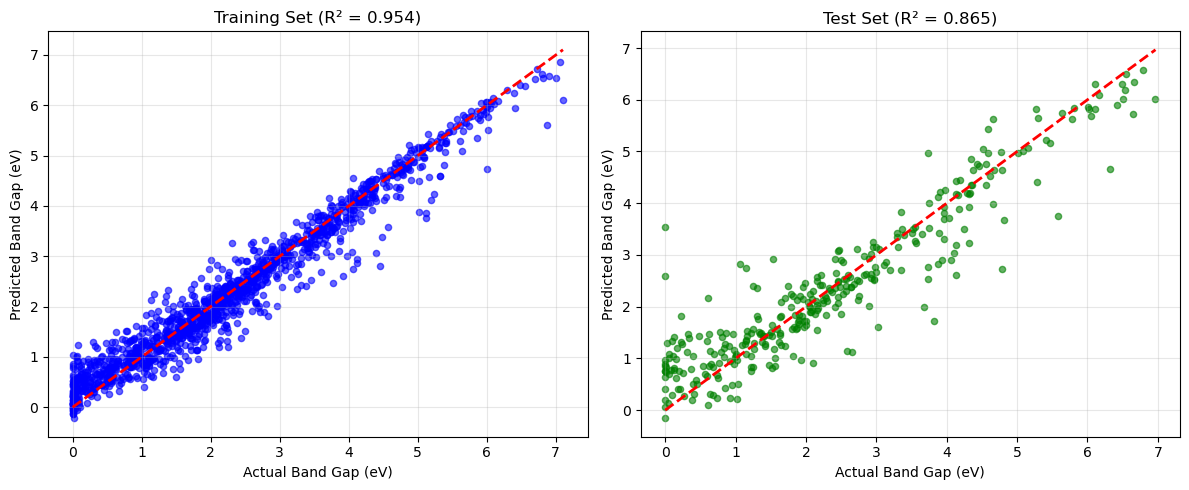


=== Feature Importance ===
efermi                   : 0.232
num_magnetic_sites       : 0.217
num_unique_magnetic_sites: 0.176
density                  : 0.151
cbm                      : 0.111
density_atomic           : 0.055
volume                   : 0.030
energy_above_hull        : 0.028

Model training complete


In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import time

# Initialize XGBoost Regressor

xgb_model = xgb.XGBRegressor(
    n_estimators=200,           
    max_depth=4,                
    learning_rate=0.07,         
    subsample=0.8, 
    colsample_bytree=0.8,      
    reg_alpha=0.1,              
    reg_lambda=0.1,             
    random_state=42
)

print(f"Model parameters: {xgb_model.get_params()}")

# Train the model
start_time = time.time()
xgb_model.fit(X_train, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Training:")
print(f"MAE: {train_mae:.3f} eV")
print(f"MSE: {train_mse:.3f} eV^2")
print(f"R^2: {train_r2:.3f}")

print(f"Test:")
print(f"MAE: {test_mae:.3f} eV")
print(f"MSE: {test_mse:.3f} eV^2")
print(f"R^2: {test_r2:.3f}")

# Actual vs Predicted plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Training set
axes[0].scatter(y_train, y_train_pred, color='blue')
axes[0].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Band Gap (eV)')
axes[0].set_ylabel('Predicted Band Gap (eV)')
axes[0].set_title(f'Training Set (R² = {train_r2:.3f})')
axes[0].grid(True, alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Band Gap (eV)')
axes[1].set_ylabel('Predicted Band Gap (eV)')
axes[1].set_title(f'Test Set (R² = {test_r2:.3f})')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance
feature_importance = xgb_model.feature_importances_
importance_df = pd.DataFrame({
    'feature': input_features,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"\n=== Feature Importance ===")
for _, row in importance_df.iterrows():
    print(f"{row['feature']:25}: {row['importance']:.3f}")

print(f"\nModel training complete")


### SHAP Model Interpretability Analysis

This section implements SHAP (SHapley Additive exPlanations) analysis to provide  model interpretability.This Visualizes feature importance and impact direction on predictions and shows how each feature contributes positively or negatively to band gap values


SHAP values calculated for 335 test samples


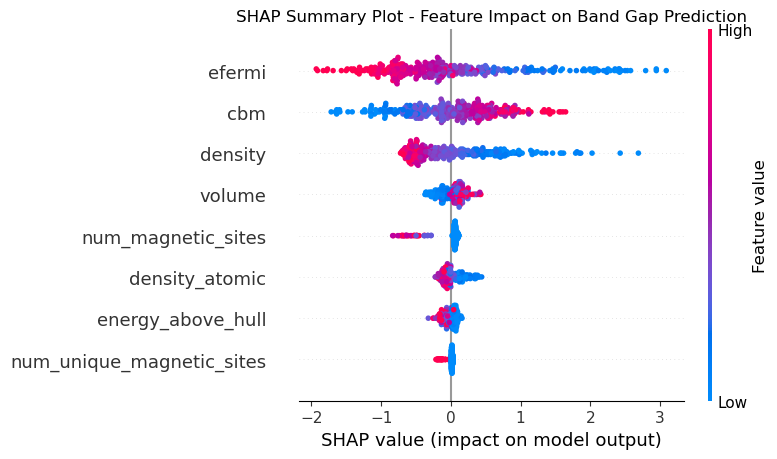

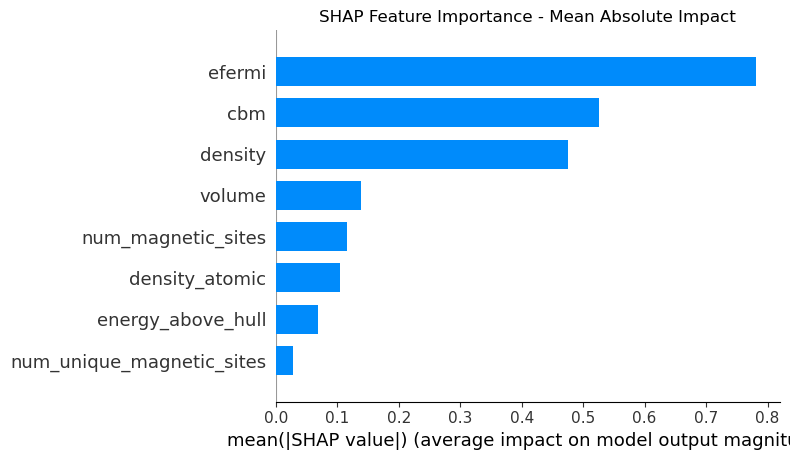

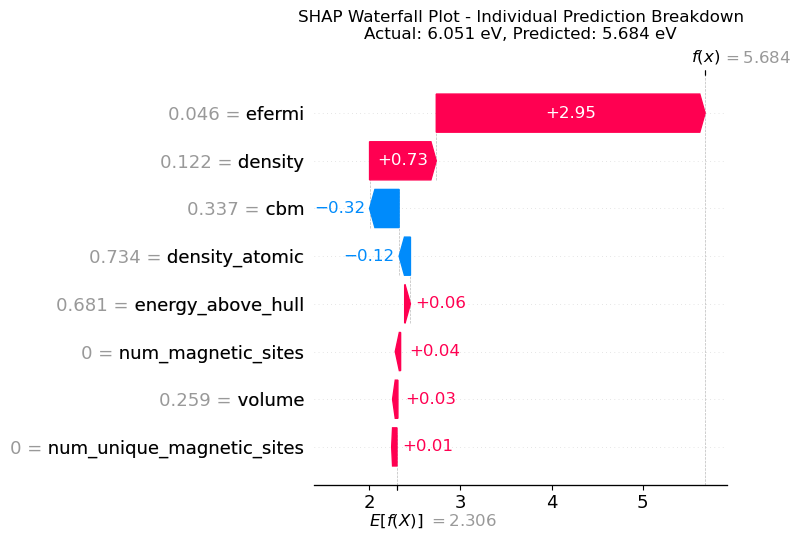

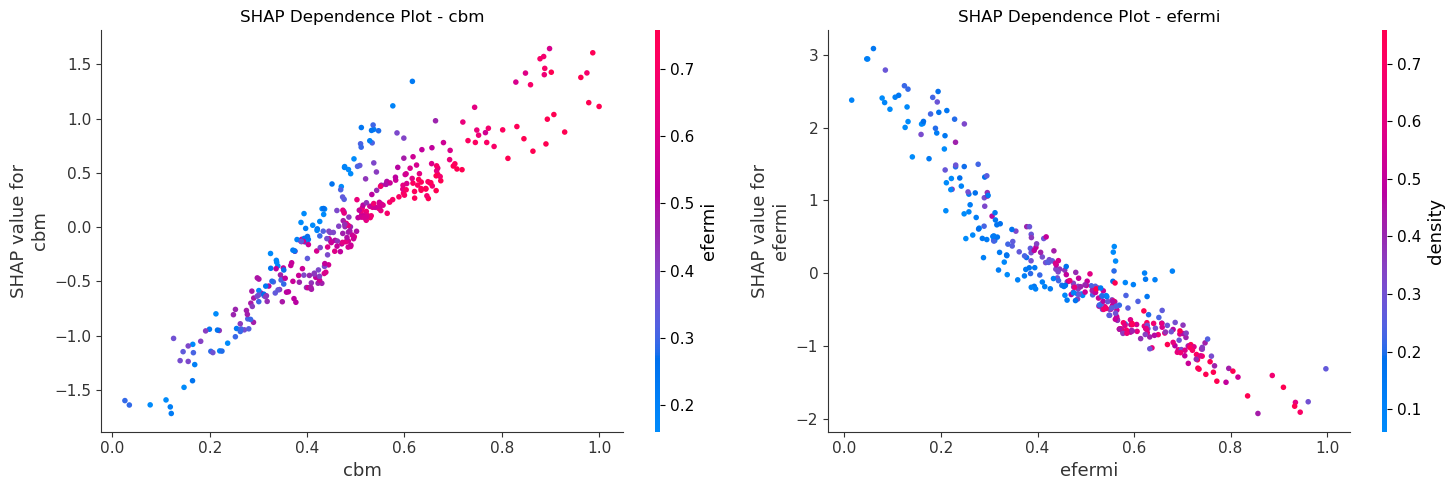


=== Feature Importance Comparison ===
Feature                   SHAP     XGBoost 
---------------------------------------------
efermi                    0.781    0.232   
cbm                       0.526    0.111   
density                   0.475    0.151   
volume                    0.138    0.030   
num_magnetic_sites        0.116    0.217   
density_atomic            0.105    0.055   
energy_above_hull         0.068    0.028   
num_unique_magnetic_sites 0.028    0.176   


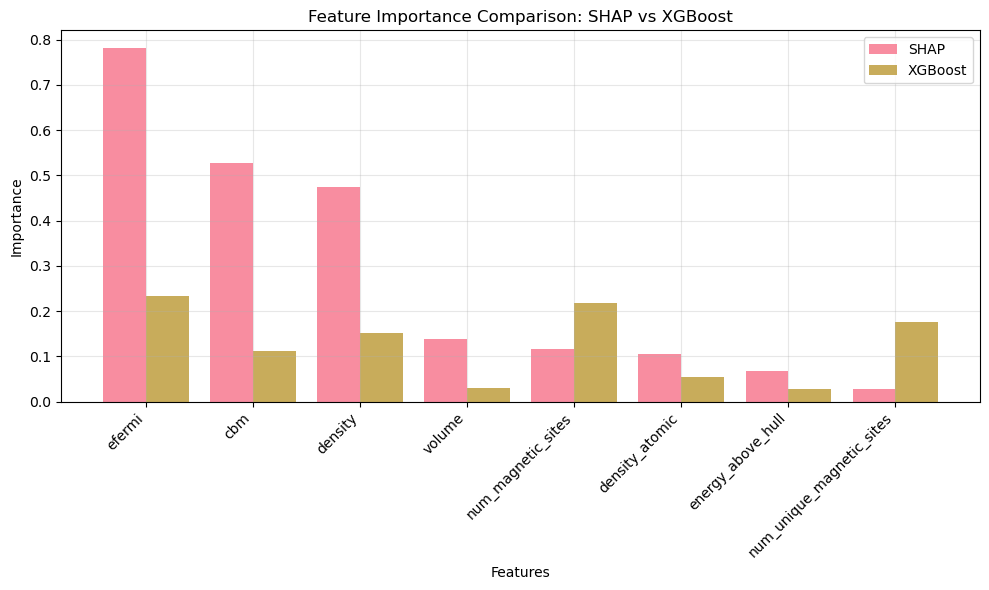

Key insights:
- Most important feature: efermi


In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Initialize SHAP explainer for tree-based models
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for test set 
shap_sample_size = min(500, len(X_test)) # Use subset for faster computation
X_shap = X_test.iloc[:shap_sample_size]
shap_values = explainer.shap_values(X_shap)

print(f"SHAP values calculated for {shap_sample_size} test samples")

# Summary plot 
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, feature_names=input_features, show=False)
plt.title('Feature Impact on Band Gap Prediction')
plt.tight_layout()
plt.show()

# Feature importance bar plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_shap, feature_names=input_features, plot_type="bar", show=False)
plt.title('Mean Absolute Impact')
plt.tight_layout()
plt.show()

# Waterfall plot for individual prediction 
sample_idx = 0 # First test sample
plt.figure(figsize=(10, 6))
shap.waterfall_plot(shap.Explanation(values=shap_values[sample_idx],
                                     base_values=explainer.expected_value,
                                     data=X_shap.iloc[sample_idx].values,
                                     feature_names=input_features), show=False)
plt.title(f'Individual Prediction Breakdown\n'
          f'Actual: {y_test.iloc[sample_idx]:.3f} eV, Predicted: {y_test_pred[sample_idx]:.3f} eV')
plt.tight_layout()
plt.show()

# Dependence plots for top 2 most important features
feature_importance_shap = np.abs(shap_values).mean(0)
top_features_idx = np.argsort(feature_importance_shap)[-2:]
top_features = [input_features[i] for i in top_features_idx]

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
for i, feature_idx in enumerate(top_features_idx):
    shap.dependence_plot(feature_idx, shap_values, X_shap,
                         feature_names=input_features, ax=axes[i], show=False)
    axes[i].set_title(f'SHAP Dependence Plot - {input_features[feature_idx]}')

plt.tight_layout()
plt.show()

# SHAP feature importance vs XGBoost feature importance comparison
shap_importance = np.abs(shap_values).mean(0)
xgb_importance = xgb_model.feature_importances_

comparison_df = pd.DataFrame({
    'Feature': input_features,
    'SHAP_Importance': shap_importance,
    'XGB_Importance': xgb_importance
}).sort_values('SHAP_Importance', ascending=False)

print(f"{'Feature':<25} {'SHAP':<8} {'XGBoost':<8}")
print("-" * 45)
for _, row in comparison_df.iterrows():
    print(f"{row['Feature']:<25} {row['SHAP_Importance']:<8.3f} {row['XGB_Importance']:<8.3f}")

# Global feature importance plot
plt.figure(figsize=(10, 6))
x_pos = np.arange(len(input_features))
plt.bar(x_pos - 0.2, comparison_df['SHAP_Importance'], 0.4, label='SHAP', alpha=0.8)
plt.bar(x_pos + 0.2, comparison_df['XGB_Importance'], 0.4, label='XGBoost', alpha=0.8)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance Comparison: SHAP vs XGBoost')
plt.xticks(x_pos, comparison_df['Feature'], rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Most important feature: {comparison_df.iloc[0]['Feature']}")

